NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

#### Installing required packages

In [2]:
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 41.6 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [4]:
rf = roboflow.Roboflow()

In [19]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
dataset_name = 'hurricanedamagev7'
dataset_version = 2
model_version = 'yolov8'
model_variant = 'n' # parameter required for model training phase

project = rf.workspace('stormdamagechallenge').project(dataset_name + '-f6aoq')
dataset = project.version(dataset_version).download(model_version)

### Import remaining packages

In [6]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Check the version of Ultralytics

In [7]:
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [10]:
!nvidia-smi

Fri Dec 13 17:22:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading YOLO model for Training


In [11]:
# Loading the model
model = YOLO(f'../models/{model_version}/{model_version}{model_variant}.pt')
# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 75.0MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

### Training Model

In [10]:
yaml_file = f'{HOME}/hurricanedamagev7-{version_dataset}/data.yaml'
yaml_file

'/content/hurricanedamagev7-2/data.yaml'

#### Resume model training from last step (optional)

In [13]:
!ls

hurricanedamagev7-2  last.pt  requirements.txt


In [15]:
# Resuming model training from last completed epoch
model = YOLO('last.pt')

In [12]:
# Train the model on the dataset for 20 epochs
batch = -1 #
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 20
patience = 5
imgsz = 512
plots = True
project = 'exploratory_phase' # parent directory name
name = 'continue_training_dataset_v2' # # run directory name

# Train the model
# model.train(data=yaml_file, batch = batch, device = device, epochs = epochs, patience = patience, imgsz = imgsz, plots = plots, project = project, name = name)

In [19]:
project = 'exploratory_phase' # parent directory name
name = 'continue_training_dataset_v2' # # run directory name
# /content/exploratory_phase/testing_data_splits_ratios/confusion_matrix_normalized.png
f'{HOME}/{project}/{name}/confusion_matrix_normalized.png'

'/content/exploratory_phase/continue_training_dataset_v2/confusion_matrix_normalized.png'

/content


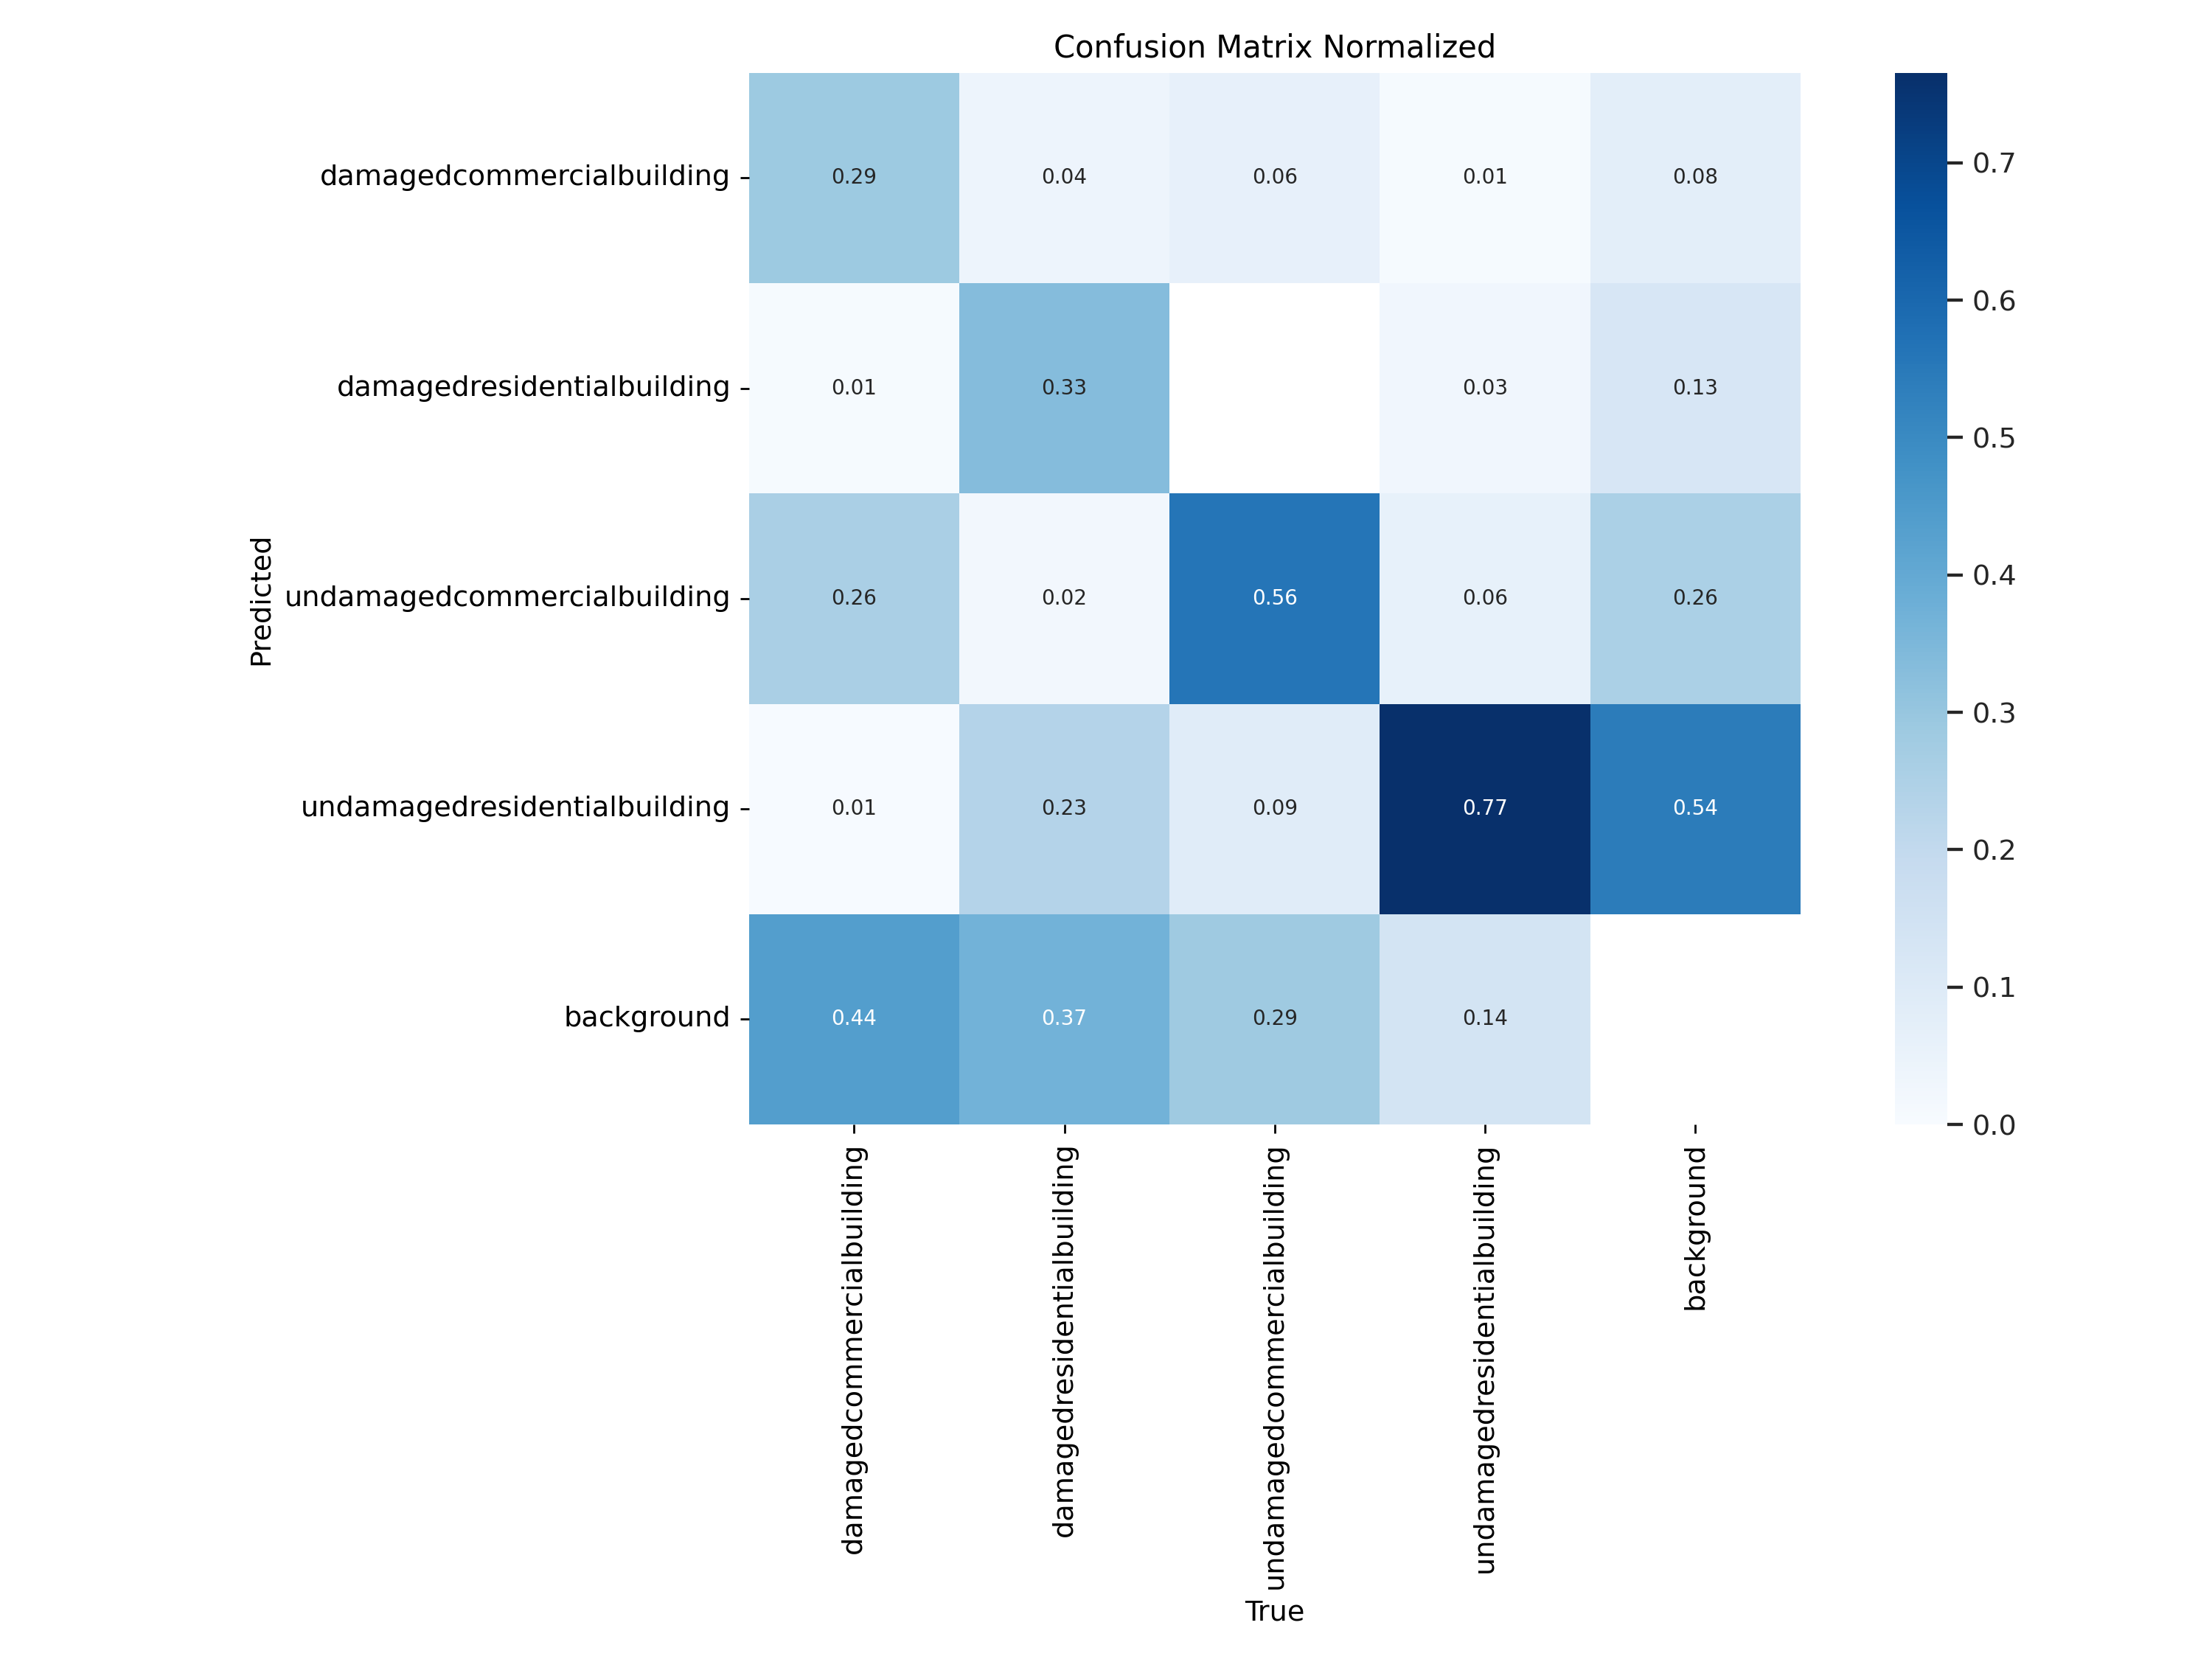

In [20]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name}/confusion_matrix_normalized.png', width=600) # FIRST RUN: 20 epochs

/content


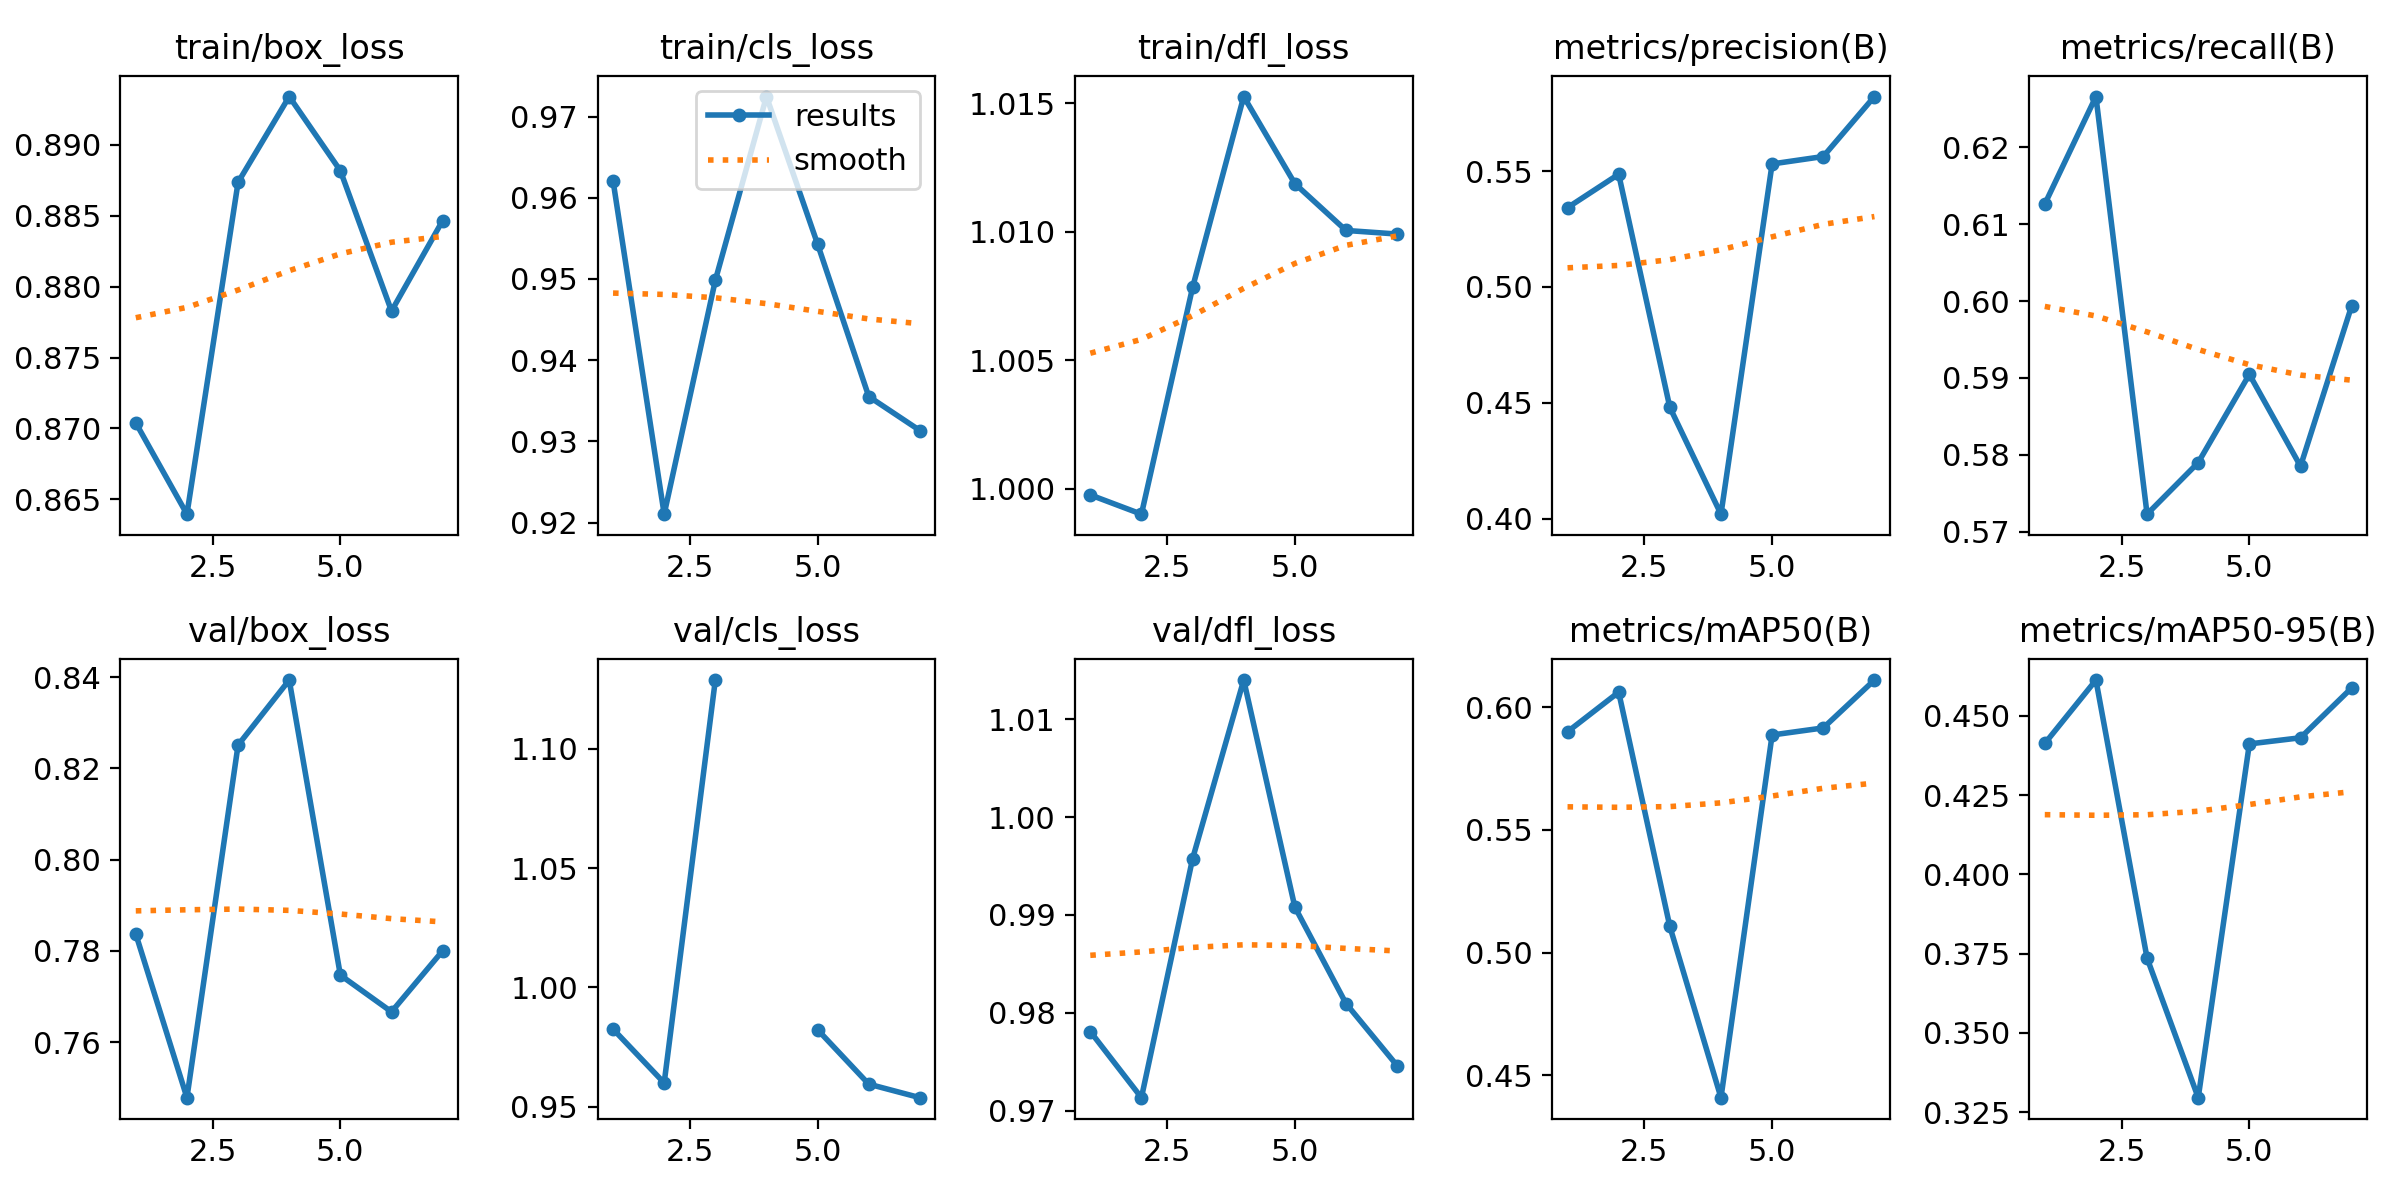

In [22]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name}/results.png', width=600)

## Testing the model performance on Test dataset

Ultralytics YOLOv8 doesn't have a separate mode=test option built-in, as it focuses on training and validation (i.e., mode=train and mode=val).

That being said, if you wish to evaluate your model on a test dataset, you can indeed do so by treating your test data as validation data. After finalizing your model from the validation stage, you can run your model on the test dataset using the mode='val'.

To do this, make sure your test dataset is in the appropriate format expected by YOLOv8. You can simply replace your /val split with your /test data when you're ready to perform testing. This way, you can use the validation mode to evaluate how your model performs on unseen data!

In [13]:
# Load the model from the best training weights
model = YOLO("best.pt")
split = 'test'
# Run the selected model
metrics_test = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 94.0MB/s]
val: Scanning /content/hurricanedamagev7-2/test/labels... 1181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:00<00:00, 1456.76it/s]

val: New cache created: /content/hurricanedamagev7-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:23<00:00,  3.15it/s]


                   all       1181      22209      0.647      0.696      0.692      0.564
damagedcommercialbuilding        437        860      0.478      0.619      0.535      0.406
damagedresidentialbuilding        846       3687      0.628      0.622      0.647      0.516
undamagedcommercialbuilding        652       2367      0.605      0.707      0.686      0.578
undamagedresidentialbuilding        865      15295      0.875      0.836      0.899      0.757
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val


In [14]:
# Load the model from the best training weights
model = YOLO("best.pt")
split = 'val'
# Run the selected model
metrics_val = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/hurricanedamagev7-2/valid/labels... 1181 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:00<00:00, 1634.07it/s]

val: New cache created: /content/hurricanedamagev7-2/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:19<00:00,  3.82it/s]


                   all       1181      21053      0.619      0.678       0.66      0.539
damagedcommercialbuilding        463        893      0.415       0.55      0.447      0.341
damagedresidentialbuilding        871       3503      0.619      0.629      0.644      0.512
undamagedcommercialbuilding        665       2449      0.576      0.691      0.652      0.545
undamagedresidentialbuilding        892      14208      0.864      0.842      0.897      0.759
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val2


In [41]:
metrics_test.box.keys

AttributeError: 'Metric' object has no attribute 'keys'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

In [35]:
print(f"The model \'{model_version}{model_variant}\' trained on dataset \'{dataset_name}-version{dataset_version}\'")
print("Below, comparison of evaluation metrics on dataset splits \'test\' and \'val\'")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - mAP of each class: {metrics_test.box.maps}")
print(f"Val dataset - mAP of each class: {metrics_val.box.maps}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_test.box.map}")
print(f"Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_val.box.map}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_test.box.map50}")
print(f"Val dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_val.box.map50}")

The model 'yolov8n' trained on dataset 'hurricanedamagev7-version2'
Below, comparison of evaluation metrics on dataset splits 'test' and 'val'
--------------------------------------------------------------------------------
Test dataset - mAP of each class: [    0.40555     0.51553     0.57787     0.75711]
Val dataset - mAP of each class: [    0.34133     0.51249     0.54457     0.75907]
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.5640130151147631
Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.539362479805987
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6919013922925458
Val dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6598951238397462


0.5640130151147631

## Downloading Results (.zip file)

In [ ]:
from google.colab import files

path_dir_to_zip = '/content/exploratory_phase/testing_data_splits_ratios' #@param {type: "string"}
output_filename = 'testing_data_splits_ratios_v2.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , path_dir_to_zip ) )

0

Download the requested zip file

In [ ]:
files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Delete the created zip file (optional)

In [ ]:
if delete_zip_file_after_download == "Yes":
    os.system( "rm -r {}".format( path_zip_file ) )

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name